## Modelo de Predicción Producción de Azúcar Total México

Se presentan dos modelos de **pronóstico** para la *Producción de Azúcar Total MX* en toneladas métricas crudas, por medio de dos enfoques:

- Modelo Autoregresivo de Series de Tiempo.
- Modelo Autoregresivo de Series de Tiempo con Variables Exógenas.

Los modelos de Series Temporales son una descomposición aditiva / multiplicativa, en la que se identifican y separan tres componentes principales de la serie temporal:

- Tendencia (Trend).
- Estacionalidad (Seasonality).
- Eventos Excepcionales (Vacations / Holidays / Events).
- Residuos (Noise).

La presencia del componente de tendencia permite manejar evoluciones de largo plazo, mientras que la estacionalidad ayuda a capturar variaciones periódicas.

El objetivo es identificar los patrones de correlación temporal que permitan transformar la serie temporal en una serie *estacionaria* en la que puede ajustarse un modelo estadístico.

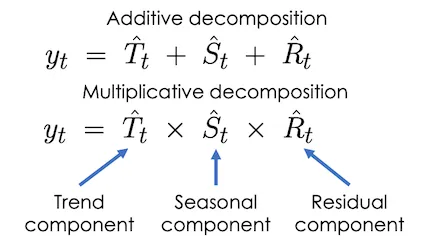


La información de la tasa de cambio, así como de los regresores exógenos son obtenidos del **Economic Research Service** del USDA (U.S. Department of Agriculture)

(https://www.ers.usda.gov/data-products/sugar-and-sweeteners-yearbook-tables/)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric
import statsmodels.formula.api as smf

### Dataset

El siguiente conjunto de datos se obtuvo por medio del **Economic Research Service** del USDA (U.S. Department of Agriculture) (https://www.ers.usda.gov/data-products/sugar-and-sweeteners-yearbook-tables/) e incluye la siguiente consulta sobre indicadores de producción por de azúcar por año fiscal (Oct-Sept) de México de los últimos **30 años**:

- Producción Total
- Inventarios Iniciales
- Importaciones
- Oferta Total
- Consumo Total (Disappearance)
- Exportaciones
- Uso Total
- Inventarios Finales
- Stocks para consumo humano
- Stocks para uso

Obtenidos de la base de datos *U.S. sugar crop production and sugar production, deliveries, and stocks* actualizada el 28/Junio/2024

Así mismo, datos de **Precipitación y Temperatura Promedio Anual** sobre México, obtenidos en el portal de Gobierno Mexicano:
- https://datos.gob.mx/busca/dataset/precipitacion
- https://datos.gob.mx/busca/dataset/temperatura-promedio-excel


In [2]:
# .csv Sugar Production, Deliveries and Stocks
mx_df = pd.read_csv("SUGARMX.csv")
mx_df['Year'] = pd.to_datetime(mx_df['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df.rename(columns={'Production':'y','Year':'ds'},inplace=True)
mx_df.drop(mx_df.tail(1).index,inplace=True) # drop last n rows
mx_df

,Fiscal year (Oct/Sept),ds,y,Beginning stocks,Imports,Supply,Disappearance,Exports,Total use,Ending stocks,Stocks-to-human consumption,Stocks-to-use,HFCS consumption (dry weight),Previous Year Precipitation,Previous Year Temperature
0,1995/96,1996-12-31,4642.00000,1587.000000,234.000000,6463.000000,4414.000000,646.000000,5060.000000,1403.000000,32.304858,27.727273,123.374946,766.80,21.173363
1,1996/97,1997-12-31,4818.00000,1403.000000,191.000000,6412.000000,4391.000000,966.000000,5357.000000,1055.000000,24.529179,19.693859,425.802000,664.40,20.828869
2,1997/98,1998-12-31,5486.00000,1055.000000,31.000000,6572.000000,4505.000000,1076.000000,5581.000000,991.000000,22.568891,17.756674,433.881320,692.10,20.722723
3,1998/99,1999-12-31,4982.00000,991.000000,41.000000,6014.000000,4549.000000,524.000000,5073.000000,941.000000,21.279964,18.549182,508.270000,741.00,21.239854
4,1999/00,2000-12-31,4979.00000,941.000000,37.000000,5957.000000,4576.000000,318.000000,4894.000000,1063.000000,23.914511,21.720474,614.800000,754.10,20.749099
5,2000/01,2001-12-31,5220.00000,1063.000000,43.000000,6326.000000,4623.000000,155.000000,4778.000000,1548.000000,34.545860,32.398493,636.000000,765.20,20.816391
6,2001/02,2002-12-31,5169.00000,1548.000000,52.000000,6769.000000,5184.000000,413.000000,5597.000000,1172.000000,23.421263,20.939789,278.250000,766.10,20.743932
7,2002/03,2003-12-31,5229.00000,1172.000000,63.000000,6464.000000,5232.000000,38.000000,5270.000000,1194.000000,23.425544,22.656546,137.800000,738.90,20.936534
8,2003/04,2004-12-31,5330.00000,1194.000000,327.000000,6851.000000,5600.000000,14.000000,5614.000000,1237.000000,22.992565,22.034200,143.100000,796.10,20.955060
9,2004/05,2005-12-31,6149.00000,1237.000000,268.000000,7654.000000,5561.000000,127.510000,5688.510000,1965.490000,37.232241,34.551930,376.300000,872.20,20.867124


Text(0, 0.5, 'Toneladas Métricas')

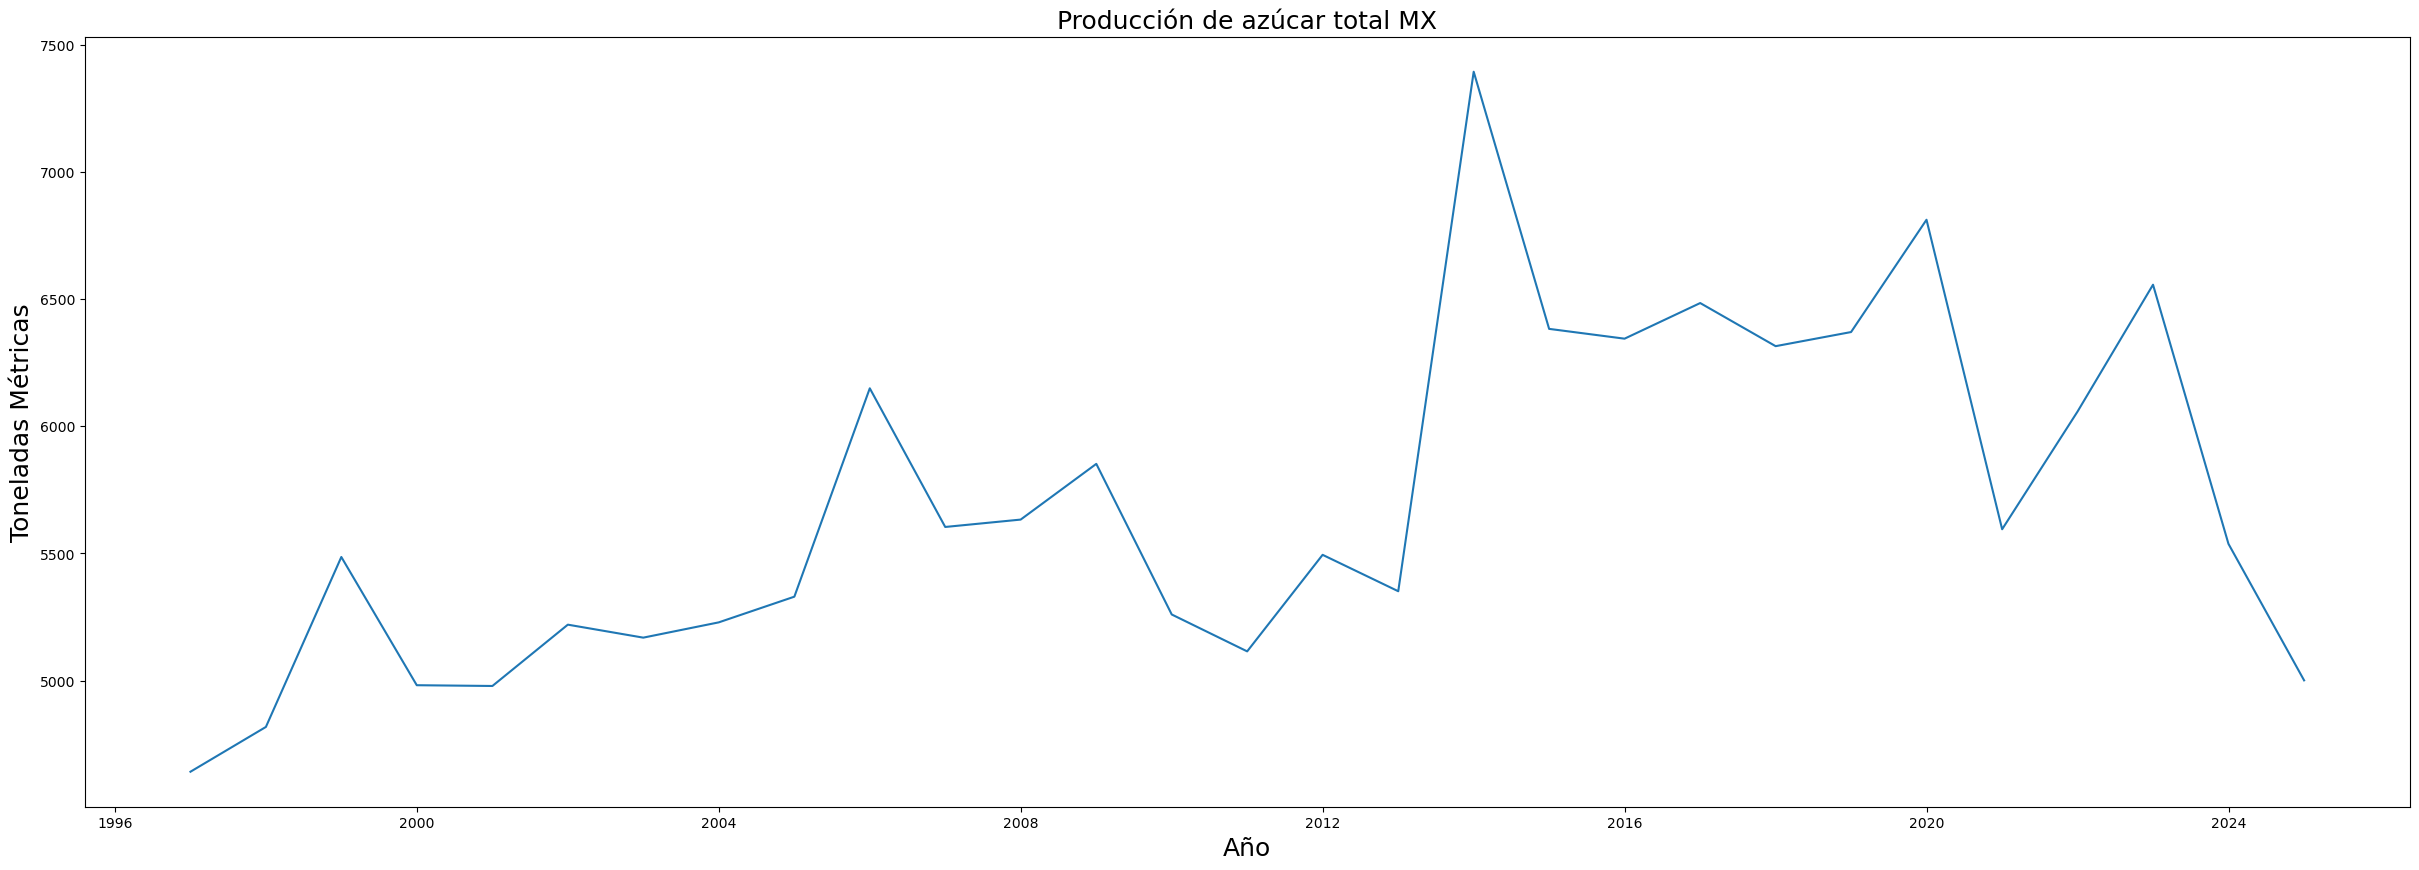

In [3]:
plt.figure(figsize=(30, 10))
plt.plot(mx_df['ds'],mx_df['y'])
plt.title("Producción de azúcar total MX" ,  fontsize=18)
plt.xlabel('Año' ,  fontsize=18)
plt.ylabel('Toneladas Métricas' , fontsize=18)

Text(0, 0.5, 'mm lluvia')

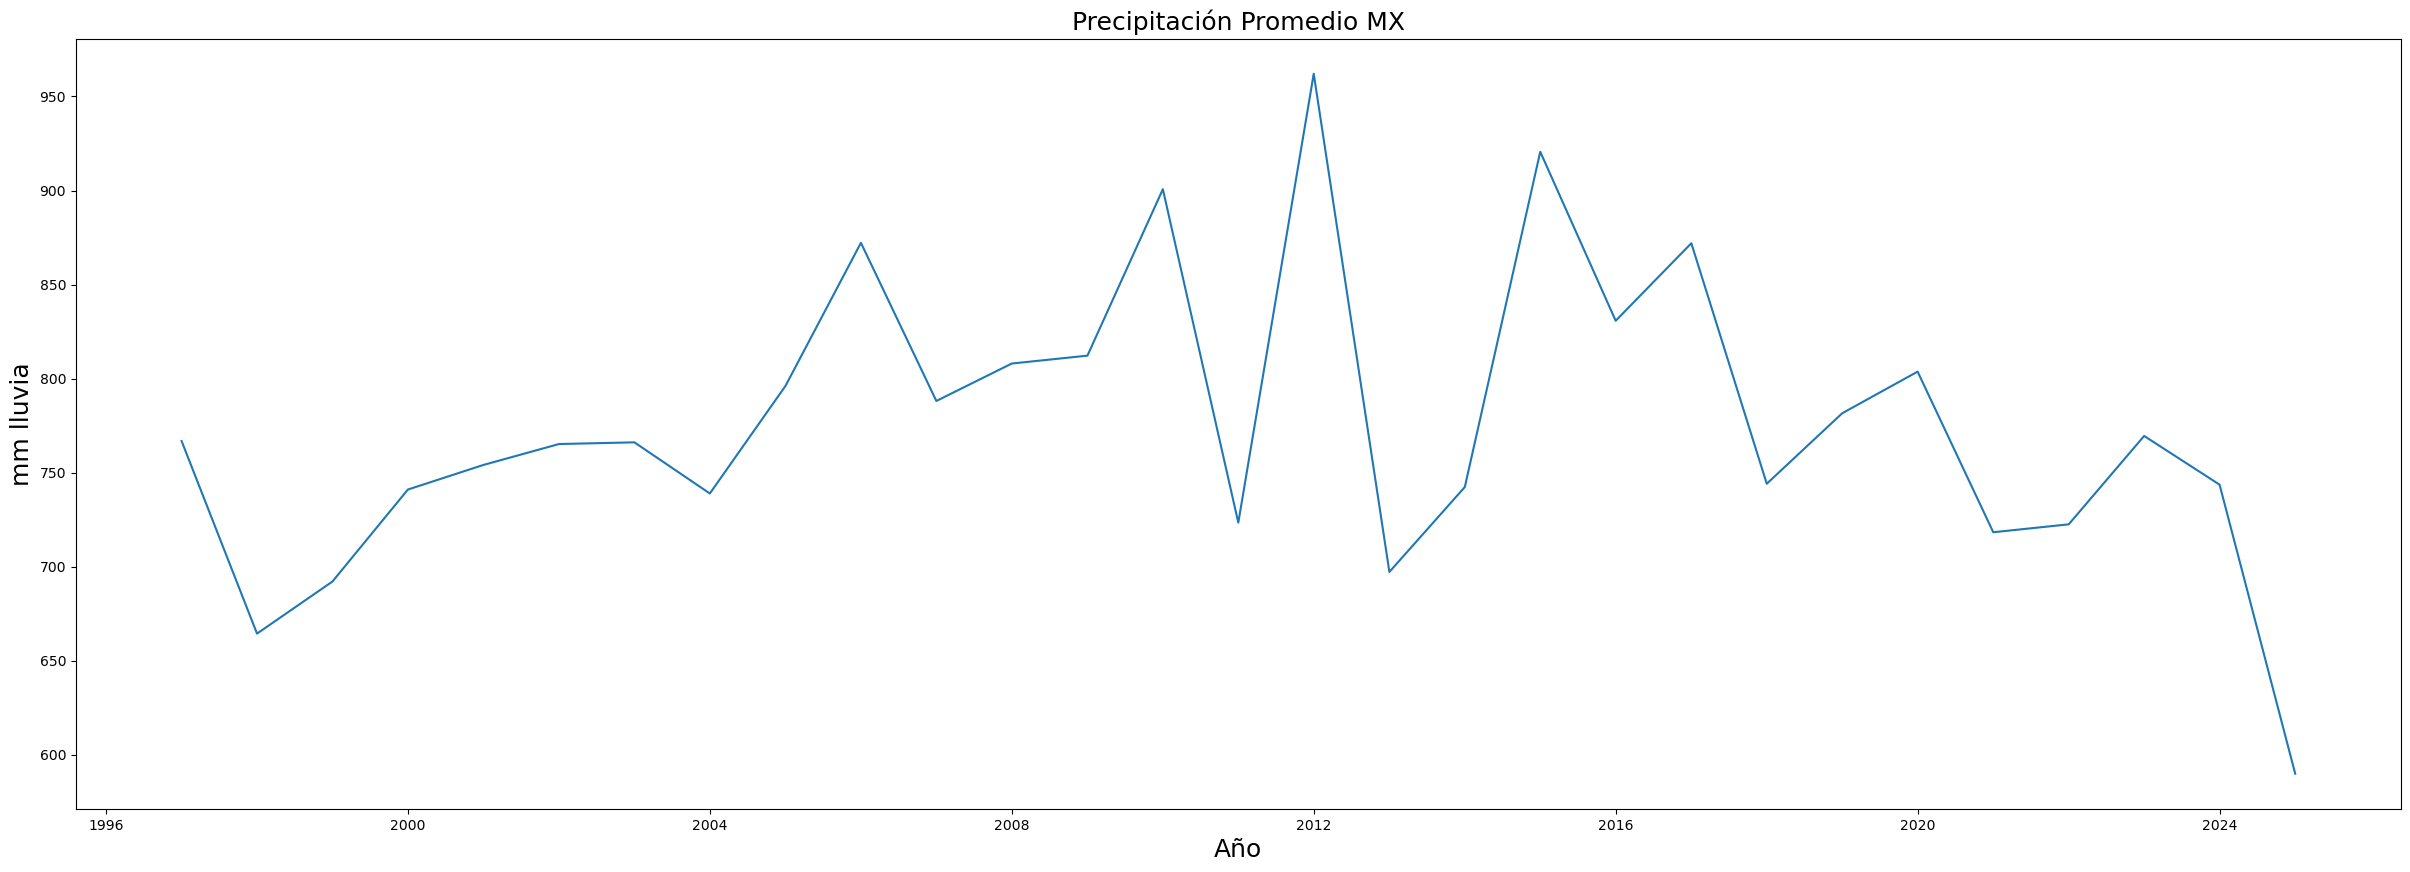

In [4]:
plt.figure(figsize=(30, 10))
plt.plot(mx_df['ds'],mx_df['Previous Year Precipitation'])
plt.title("Precipitación Promedio MX" ,  fontsize=18)
plt.xlabel('Año' ,  fontsize=18)
plt.ylabel('mm lluvia' , fontsize=18)

Text(0, 0.5, '°C')

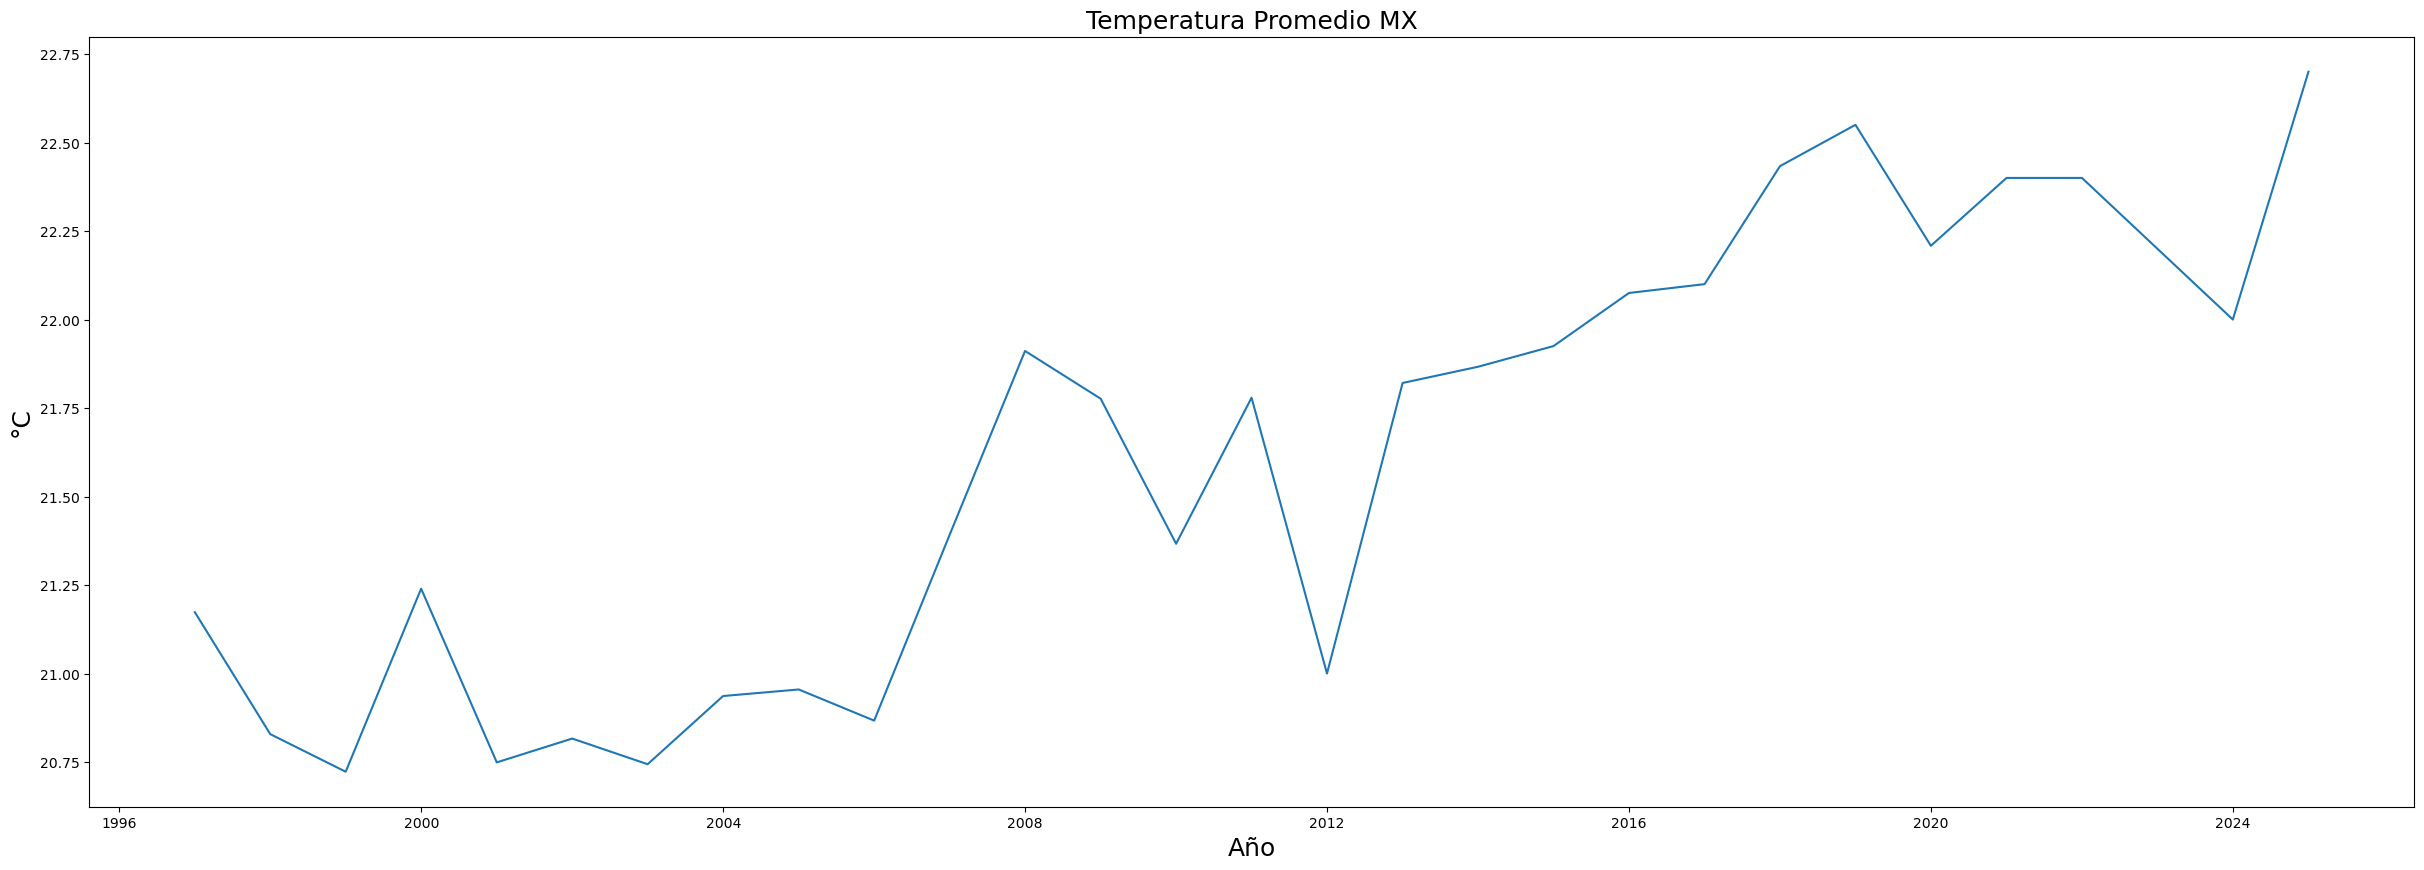

In [5]:
plt.figure(figsize=(30, 10))
plt.plot(mx_df['ds'],mx_df['Previous Year Temperature'])
plt.title("Temperatura Promedio MX" ,  fontsize=18)
plt.xlabel('Año' ,  fontsize=18)
plt.ylabel('°C' , fontsize=18)

### Modelo Serie Temporal Auto-Regresión

Se utiliza la librería Prophet para entrenar el modelo. Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.

In [6]:
model = Prophet(interval_width = 0.95)
model.fit(mx_df)
df_cv = cross_validation(model, initial='365 days', period='365 days', horizon = '365 days')
df_cv

09:13:46 - cmdstanpy - INFO - Chain [1] start processing
09:13:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/27 [00:00<?, ?it/s]

09:13:46 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1] done processing
09:13:47 - cmdstanpy - INFO - Chain [1] start processing
09:13:47 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1998-12-31,5000.686126,5000.686049,5000.686200,5486.00000,1998-01-07
1,1999-12-31,5957.145687,5786.188244,6144.002705,4982.00000,1999-01-07
2,2000-12-31,4756.912083,4282.363837,5181.006919,4979.00000,2000-01-07
3,2001-12-31,5221.647652,4756.452580,5623.762131,5220.00000,2001-01-06
4,2002-12-31,5394.524066,5047.249331,5743.499226,5169.00000,2002-01-06
5,2003-12-31,5344.285368,4989.306937,5705.162138,5229.00000,2003-01-06
6,2004-12-31,5089.149106,4751.059666,5403.827957,5330.00000,2004-01-06
7,2005-12-31,5425.789952,5096.200714,5739.953107,6149.00000,2005-01-05
8,2006-12-31,5822.313749,5382.211148,6302.372187,5604.00000,2006-01-05
9,2007-12-31,5737.703919,5280.504916,6157.550125,5633.00000,2007-01-05


#### Métricas de Validación Cruzada

In [7]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,358 days,593219.333319,770.207331,730.229780,0.142099,0.142099,0.135422,0.00
1,359 days,28369.394507,168.432166,141.136251,0.027649,0.032839,0.027611,1.00
2,360 days,159916.432613,399.895527,321.769653,0.055087,0.042072,0.056956,0.75
3,361 days,296391.788551,544.418762,448.906334,0.085529,0.090288,0.080466,0.50
4,362 days,787434.287144,887.374942,631.323163,0.092493,0.053262,0.099842,0.75


/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


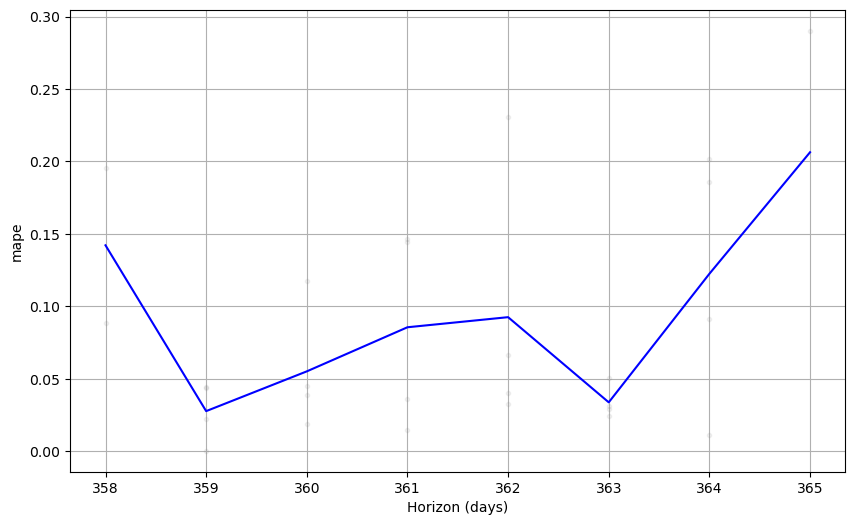

In [8]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Puede observarse que el horizonte de pronóstico con menor error es a **359 días** con un error porcentual del 2.8%

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado.

In [9]:
n_forecast = 4
future = model.make_future_dataframe(periods=n_forecast, freq='YE')
forecast = model.predict(future)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
30,2026-12-31,-4035.402519,5496.756155,7545.711423,-4035.425551,-4035.381342,10561.988536,10561.988536,10561.988536,10561.988536,10561.988536,10561.988536,0.0,0.0,0.0,6526.586017
31,2027-12-31,-3989.986590,5471.426988,7572.319696,-3990.033899,-3989.947275,10514.062454,10514.062454,10514.062454,10514.062454,10514.062454,10514.062454,0.0,0.0,0.0,6524.075865
32,2028-12-31,-3944.446232,5320.280453,7331.781153,-3944.517791,-3944.386074,10292.271745,10292.271745,10292.271745,10292.271745,10292.271745,10292.271745,0.0,0.0,0.0,6347.825512


In [10]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
28,2024-12-31,6166.037365,5208.247502,7157.026862
29,2025-12-31,6407.212935,5369.689206,7360.720658
30,2026-12-31,6526.586017,5496.756155,7545.711423
31,2027-12-31,6524.075865,5471.426988,7572.319696
32,2028-12-31,6347.825512,5320.280453,7331.781153


<Figure size 1500x700 with 0 Axes>

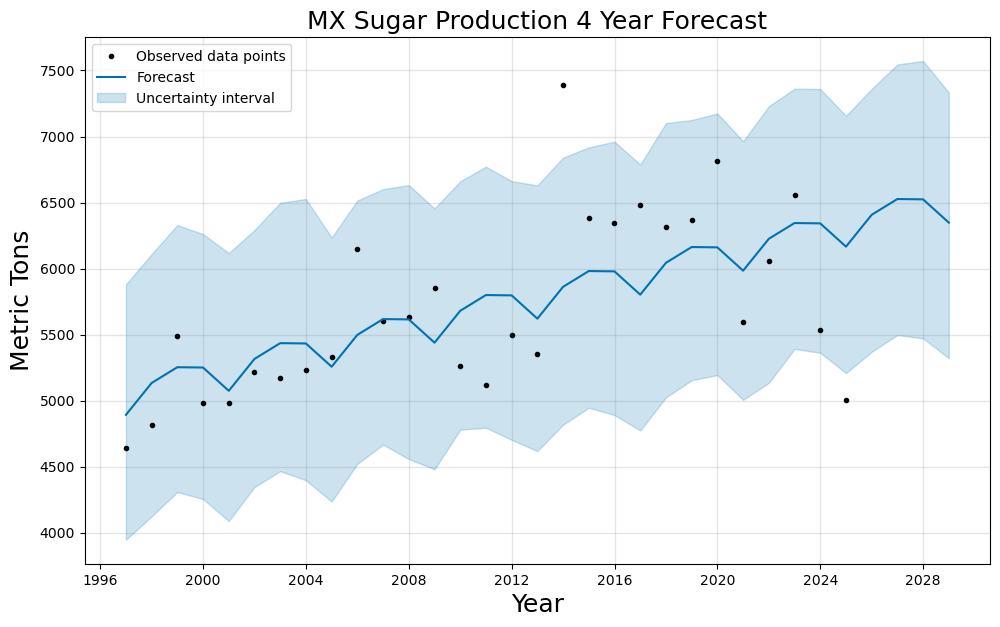

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast)
    plt.legend(loc='upper left')
    plt.title("MX Sugar Production {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Metric Tons' , fontsize=18)

#### Análisis de Componentes: Tendencia + Estacionalidad

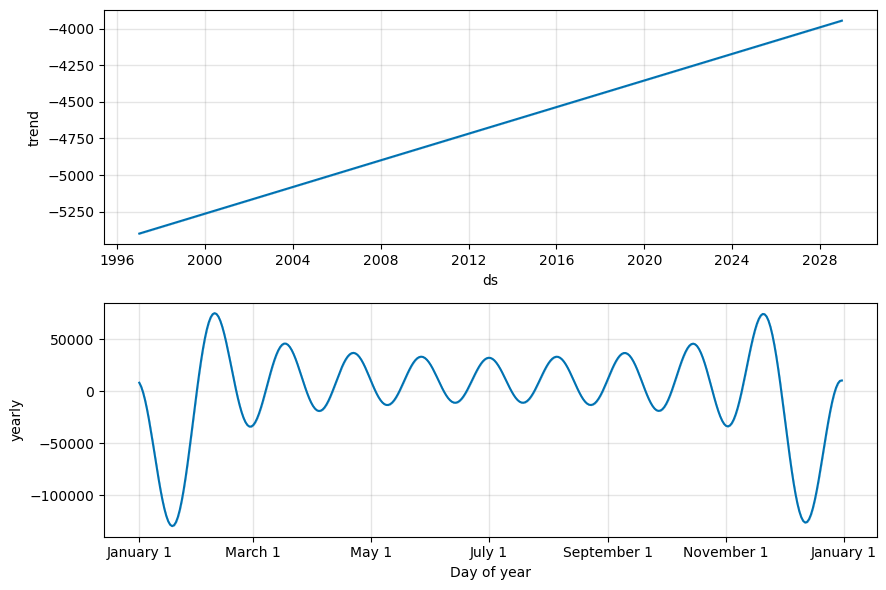

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    fig = model.plot_components(forecast)

### Modelo Serie Temporal Auto-Regresión con Regresores Exógenos

Se utiliza la librería Prophet para entrenar el modelo, incluyendo **regresores exógenos** que consisten en valores anualizados de variables climatológicas de México durante los últimos 30 años.

Así mismo, datos de **Precipitación y Temperatura Promedio Anual** sobre México, obtenidos en el portal de Gobierno Mexicano:

- Temperatura Promedio Anual (°C)
- Precipitación Acumulada Anual (mm)

Obtenidos de la base de datos *Portal de Gobierno Mexicano*.


Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.


#### Correlograma

<Axes: title={'center': 'USD - MXN Exchange Rate Correlogram'}>

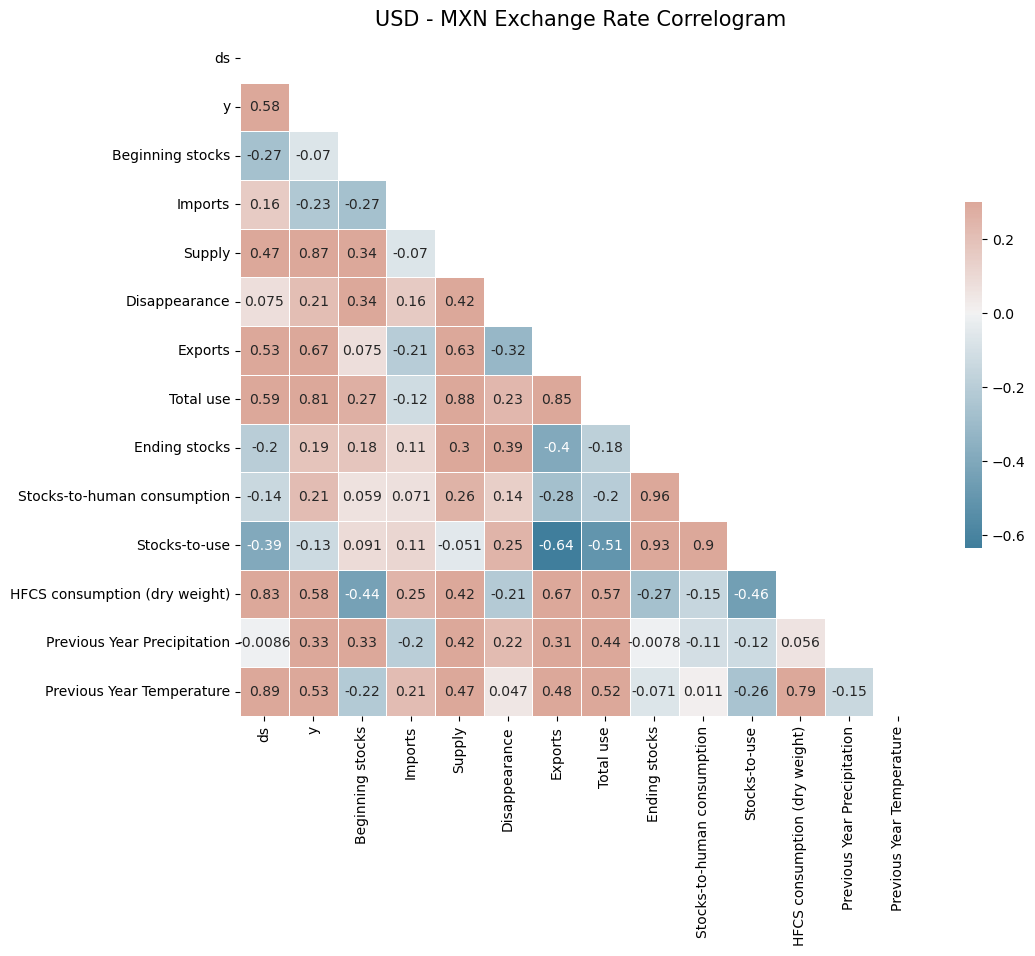

In [13]:
# Compute the correlation matrix
corr = mx_df.iloc[:,1:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title("USD - MXN Exchange Rate Correlogram",size=15)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

La correlación de la Producción Total con la Precipitación (Lag 1 año) y la Temperatura (Lag 1 año) es de 0.33 y 0.53 respectivamente. Se utilizarán estos regresores para el modelo.

In [14]:
model = Prophet(interval_width = 0.95)
model.add_regressor('Previous Year Precipitation',standardize=True)
model.add_regressor('Previous Year Temperature',standardize=True)
model.fit(mx_df)
df_cv = cross_validation(model, initial='365 days', period='365 days', horizon = '365 days')
df_cv

09:13:49 - cmdstanpy - INFO - Chain [1] start processing
09:13:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/27 [00:00<?, ?it/s]

09:13:49 - cmdstanpy - INFO - Chain [1] start processing
09:13:49 - cmdstanpy - INFO - Chain [1] done processing
09:13:49 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1] done processing
09:13:50 - cmdstanpy - INFO - Chain [1] start processing
09:13:50 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1998-12-31,7926.529714,7926.529647,7926.529777,5486.00000,1998-01-07
1,1999-12-31,-4602.556723,-4602.556756,-4602.556691,4982.00000,1999-01-07
2,2000-12-31,11025.911492,11025.911463,11025.911519,4979.00000,2000-01-07
3,2001-12-31,5112.392660,5112.392631,5112.392686,5220.00000,2001-01-06
4,2002-12-31,5617.627169,5612.625111,5623.262327,5169.00000,2002-01-06
5,2003-12-31,5061.161398,4858.650444,5291.746939,5229.00000,2003-01-06
6,2004-12-31,4570.238346,4357.478251,4777.733167,5330.00000,2004-01-06
7,2005-12-31,5357.115457,5051.597934,5665.627303,6149.00000,2005-01-05
8,2006-12-31,5132.164852,4750.646921,5517.506534,5604.00000,2006-01-05
9,2007-12-31,5367.017609,5009.663818,5758.973651,5633.00000,2007-01-05


#### Métricas de Validación Cruzada¶

In [15]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,358 days,4.890996e+07,6993.565359,6012.543218,1.184351,1.184351,1.181959,0.00
1,359 days,9.201539e+06,3033.403784,1692.746151,0.338497,0.059445,0.223066,0.25
2,360 days,3.744235e+05,611.901532,572.365934,0.100685,0.106489,0.106847,0.25
3,361 days,5.011408e+05,707.913012,690.563759,0.128716,0.134994,0.121950,0.00
4,362 days,8.891836e+05,942.965302,620.516773,0.088362,0.039847,0.097612,0.75


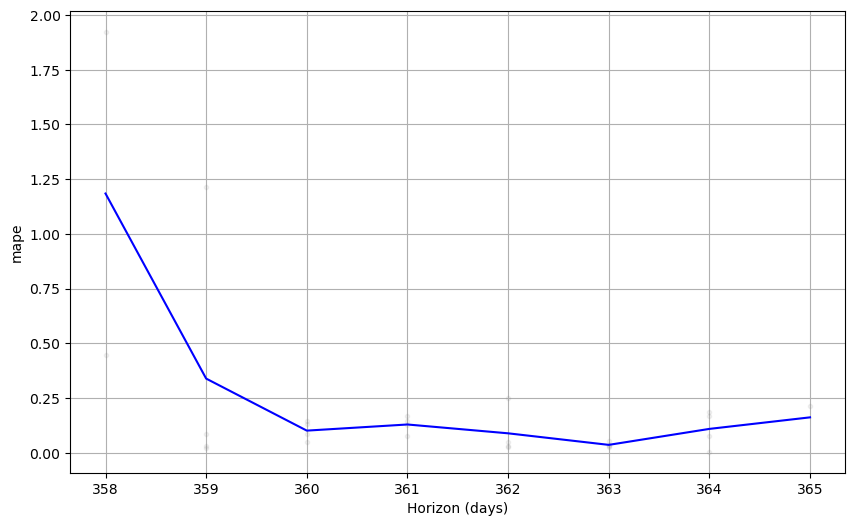

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    fig = plot_cross_validation_metric(df_cv, metric='mape')

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado, utilizando los regresores exógenos de Precipitación y Temperatura.

Con el objetivo de poder usar los regresores de precipitación y temperatura para el pronóstico, se necesitan los pronósticos de precipitación y temperatura para el horizonte temporal. Se recomienda obtener estos estimados de fuentes oficiales. Para este ejercicio se hará una Regresión Lineal OLS simple para proyectar los siguientes años.

In [17]:
# Years History for Precipitation and Temperature Linear Regression Estimate
years = 5

# Year Feature
mx_df['Year']= pd.DatetimeIndex(mx_df['ds']).year

# Multivariate OLS
OLS_model_precipitation = smf.ols("Q('Previous Year Precipitation') ~ Year",data=mx_df.iloc[:years,:]).fit()
OLS_model_temperature = smf.ols("Q('Previous Year Temperature') ~ Year",data=mx_df.iloc[:years,:]).fit()

In [18]:
# .csv Global Key Indicators Forecasts from EIU
mx_df_ext = pd.read_csv("PDREGR.csv")
mx_df_ext['Date'] = pd.to_datetime(mx_df_ext['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df_ext

,Year,Date
0,2025,2025-12-31
1,2026,2026-12-31
2,2027,2027-12-31
3,2028,2028-12-31


In [19]:
# Precipitation forecast
precipitation_forecast = pd.DataFrame(OLS_model_precipitation.predict(mx_df_ext['Year']),columns=['Previous Year Precipitation'])
pd_hat_forecast = pd.concat([mx_df_ext,precipitation_forecast],axis=1)

# Temperature forecast
temperature_forecast = pd.DataFrame(OLS_model_temperature.predict(mx_df_ext['Year']),columns=['Previous Year Temperature'])
mx_df_ext = pd.concat([pd_hat_forecast,temperature_forecast],axis=1)

mx_df_ext

,Year,Date,Previous Year Precipitation,Previous Year Temperature
0,2025,2025-12-31,861.92,19.761412
1,2026,2026-12-31,867.04,19.717658
2,2027,2027-12-31,872.16,19.673903
3,2028,2028-12-31,877.28,19.630149


#### Multivariate Time Series Regression

In [20]:
mx_df_ext.rename(columns={'Date':'ds'},inplace=True)

n_forecast = 4
future = pd.concat([mx_df,mx_df_ext],axis=0)
future
forecast_ext = model.predict(future)
forecast_ext.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Previous Year Precipitation,Previous Year Precipitation_lower,Previous Year Precipitation_upper,Previous Year Temperature,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
28,2024-12-31,-6144.116310,4840.750968,6592.827799,-6144.116310,-6144.116310,-584.987131,-584.987131,-584.987131,431.705238,...,-153.281893,-153.281893,-153.281893,11981.224137,11981.224137,11981.224137,0.0,0.0,0.0,5683.825935
29,2025-12-31,-6124.834283,4652.356685,6450.387285,-6124.834418,-6124.834145,272.717682,272.717682,272.717682,-741.325720,...,-468.608038,-468.608038,-468.608038,12169.633910,12169.633910,12169.633910,0.0,0.0,0.0,5576.191589
30,2026-12-31,-6105.552256,4679.359607,6499.220204,-6105.552671,-6105.551812,288.861527,288.861527,288.861527,-758.791690,...,-469.930164,-469.930164,-469.930164,12208.264953,12208.264953,12208.264953,0.0,0.0,0.0,5632.782533
31,2027-12-31,-6086.270230,4715.340613,6434.221277,-6086.271054,-6086.269415,305.005371,305.005371,305.005371,-776.257661,...,-471.252290,-471.252290,-471.252290,12097.081627,12097.081627,12097.081627,0.0,0.0,0.0,5539.559108
32,2028-12-31,-6066.935376,4566.457746,6347.229590,-6066.936664,-6066.934062,321.149216,321.149216,321.149216,-793.723632,...,-472.574416,-472.574416,-472.574416,11981.224137,11981.224137,11981.224137,0.0,0.0,0.0,5441.714346


In [21]:
forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(4)

,ds,yhat,yhat_lower,yhat_upper
29,2025-12-31,5576.191589,4652.356685,6450.387285
30,2026-12-31,5632.782533,4679.359607,6499.220204
31,2027-12-31,5539.559108,4715.340613,6434.221277
32,2028-12-31,5441.714346,4566.457746,6347.229590


<Figure size 1500x700 with 0 Axes>

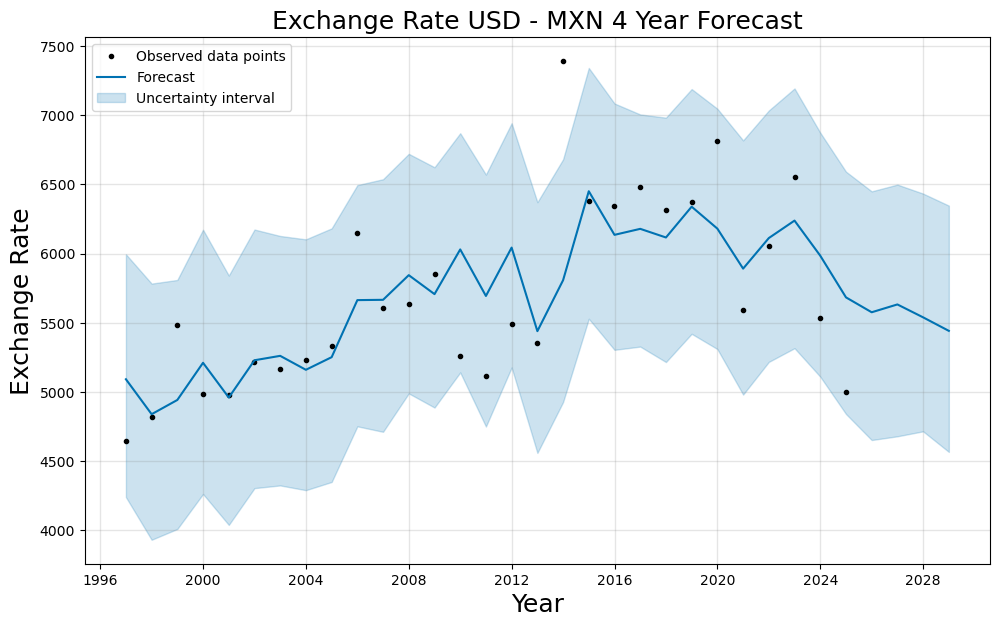

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast_ext)
    plt.legend(loc='upper left')
    plt.title("Exchange Rate USD - MXN {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Exchange Rate' , fontsize=18)

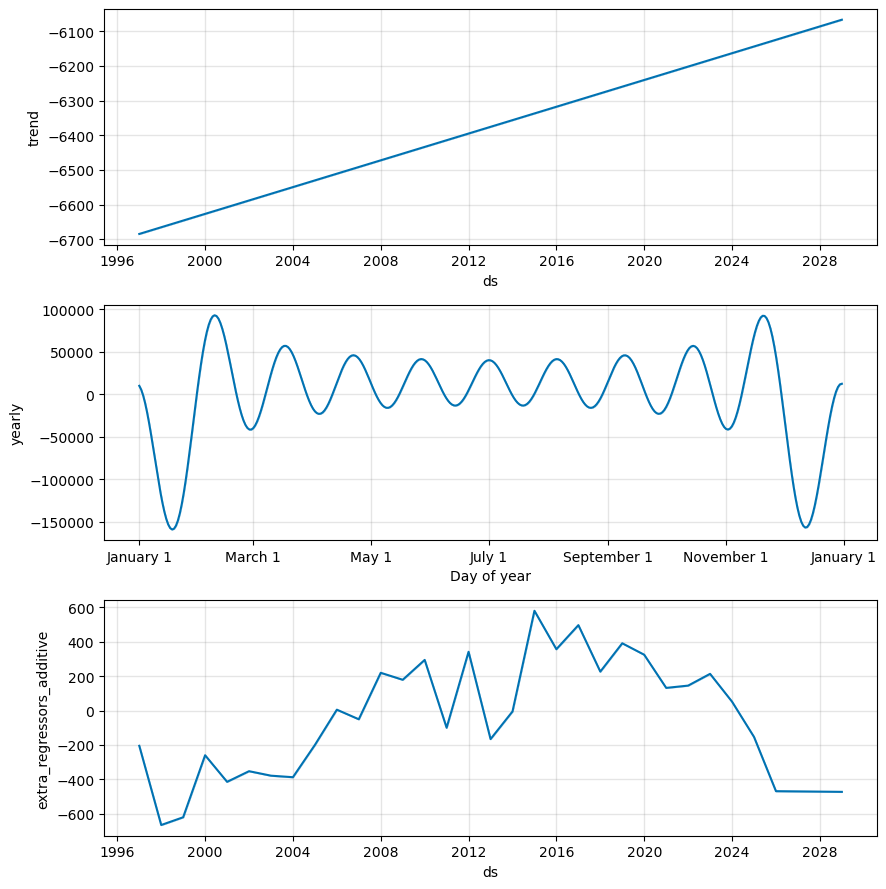

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    model.plot_components(forecast_ext)

### Resumen Resultados

#### Serie Temporal Simple

In [24]:
serie_temporal = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal.rename(columns={"yhat": "Producción Global MX (Raw Metric Tons)", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"},inplace=True)
serie_temporal

,ds,Producción Global MX (Raw Metric Tons),LI 95% Confianza,LS 95% Confianza
28,2024-12-31,6166.037365,5208.247502,7157.026862
29,2025-12-31,6407.212935,5369.689206,7360.720658
30,2026-12-31,6526.586017,5496.756155,7545.711423
31,2027-12-31,6524.075865,5471.426988,7572.319696
32,2028-12-31,6347.825512,5320.280453,7331.781153


#### Serie Temporal con Regresores

In [25]:
serie_temporal_reg = forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal_reg.rename(columns={"yhat": "Producción Global MX (Raw Metric Tons)", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"},inplace=True)
serie_temporal_reg

,ds,Producción Global MX (Raw Metric Tons),LI 95% Confianza,LS 95% Confianza
28,2024-12-31,5683.825935,4840.750968,6592.827799
29,2025-12-31,5576.191589,4652.356685,6450.387285
30,2026-12-31,5632.782533,4679.359607,6499.220204
31,2027-12-31,5539.559108,4715.340613,6434.221277
32,2028-12-31,5441.714346,4566.457746,6347.229590


#### Promedio de Ensamble

In [28]:
df_concat = pd.concat((serie_temporal_reg, serie_temporal))
plt_df = df_concat.groupby('ds').mean()
plt_df

,Producción Global MX (Raw Metric Tons),LI 95% Confianza,LS 95% Confianza
ds,,,
2024-12-31,5924.931650,5024.499235,6874.927331
2025-12-31,5991.702262,5011.022945,6905.553971
2026-12-31,6079.684275,5088.057881,7022.465813
2027-12-31,6031.817486,5093.383800,7003.270487
2028-12-31,5894.769929,4943.369100,6839.505371


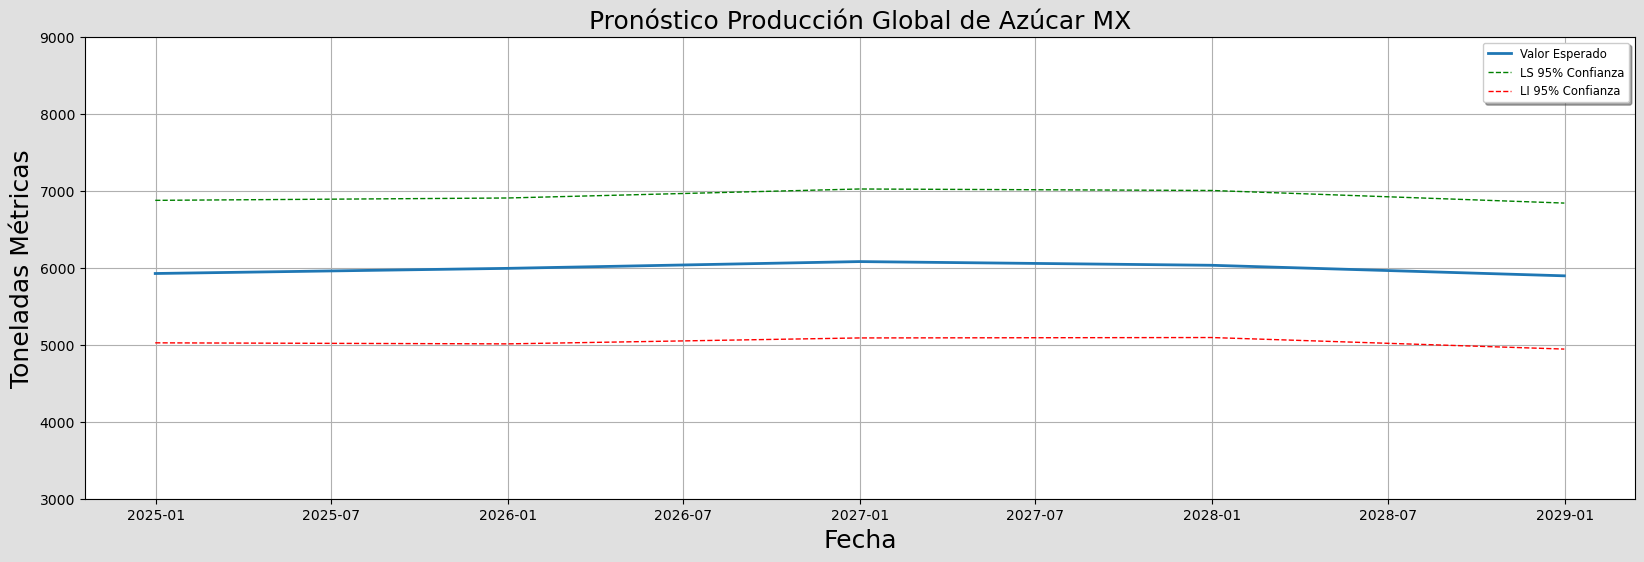

In [72]:
fig, ax = plt.subplots(figsize=(20,6))
plt.ylim(3000, 9000)
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(plt_df.index,plt_df['Producción Global MX (Raw Metric Tons)'],linewidth=2, label='Valor Esperado')
ax.plot(plt_df.index,plt_df['LS 95% Confianza'],color='green', linestyle='dashed', linewidth=1,label='LS 95% Confianza')
ax.plot(plt_df.index,plt_df['LI 95% Confianza'],color='red', linestyle='dashed', linewidth=1,label='LI 95% Confianza')
plt.title("Pronóstico Producción Global de Azúcar MX" ,  fontsize=18)
plt.xlabel('Fecha' ,  fontsize=18)
plt.ylabel('Toneladas Métricas' , fontsize=18)
legend = ax.legend(loc='best', shadow=True, fontsize='small')